In [1]:
# Алексеев Д.П. (DSU-4,FEML-8)
# Домашнее задание к лекции «Feature Selection» обновленное» (#9).

# Задание:
# 1) Взять датасет 
# https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_covtype.html#sklearn.datasets.fetch_covtype

# 2) Провести EDA

# 3) Построить зависимость между качеством модели и количеством отобранных признаков. 
# Т.е. надо обучать модель на количестве признаков от одного до максимально возможного.

# 4) Для отбора признаков использовать следующие подходы:
# а) корреляция признаков (на основе матрицы корреляции) и отбор по величине корреляции

# б) отбор признаков на основе Information Value 
# (см. статью https://medium.com/mlearning-ai/weight-of-evidence-woe-and-information-value-iv-how-to-use-it-in-eda-and-model-building-3b3b98efe0e8)

# в) отбор признаков на основе feature_importance от алгоритма RandomForest

# г) жадный отбор признаков по максимальному нарастанию качества модели

# д) жадное отбрасывание признаков по минимальному падению качества модели

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from matplotlib import pyplot as plt

In [2]:
from sklearn import datasets
fetch_covtype = datasets.fetch_covtype(as_frame=True) # загрузим сразу как датафрейм
print(fetch_covtype.DESCR)

.. _covtype_dataset:

Forest covertypes
-----------------

The samples in this dataset correspond to 30Г—30m patches of forest in the US,
collected for the task of predicting each patch's cover type,
i.e. the dominant species of tree.
There are seven covertypes, making this a multiclass classification problem.
Each sample has 54 features, described on the
`dataset's homepage <https://archive.ics.uci.edu/ml/datasets/Covertype>`__.
Some of the features are boolean indicators,
while others are discrete or continuous measurements.

**Data Set Characteristics:**

    =================   ============
    Classes                        7
    Samples total             581012
    Dimensionality                54
    Features                     int
    =================   ============

:func:`sklearn.datasets.fetch_covtype` will load the covertype dataset;
it returns a dictionary-like 'Bunch' object
with the feature matrix in the ``data`` member
and the target values in ``target``. If optional 

In [3]:
# определим датасет, включая целевую переменную
df = fetch_covtype.data
df['covtype'] = fetch_covtype.target

In [4]:
# оценим общее качество данных
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581012 entries, 0 to 581011
Data columns (total 55 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   Elevation                           581012 non-null  float64
 1   Aspect                              581012 non-null  float64
 2   Slope                               581012 non-null  float64
 3   Horizontal_Distance_To_Hydrology    581012 non-null  float64
 4   Vertical_Distance_To_Hydrology      581012 non-null  float64
 5   Horizontal_Distance_To_Roadways     581012 non-null  float64
 6   Hillshade_9am                       581012 non-null  float64
 7   Hillshade_Noon                      581012 non-null  float64
 8   Hillshade_3pm                       581012 non-null  float64
 9   Horizontal_Distance_To_Fire_Points  581012 non-null  float64
 10  Wilderness_Area_0                   581012 non-null  float64
 11  Wilderness_Area_1         

Из df.info() мы видим, что в датасете отсутствуют пропуски, заполнение не потребуется.
А также - все переменные числовые (типа float64, int32) и нет категориальных переменных (типа 'object' или 'string'), 
т.е. энкодеры для обработки категориальных переменных применять не нужно. 
Судя по описанию к датасету и названиям признаков ('Soil_Type_number'), категориальные были уже закодированы заранее.

<AxesSubplot:>

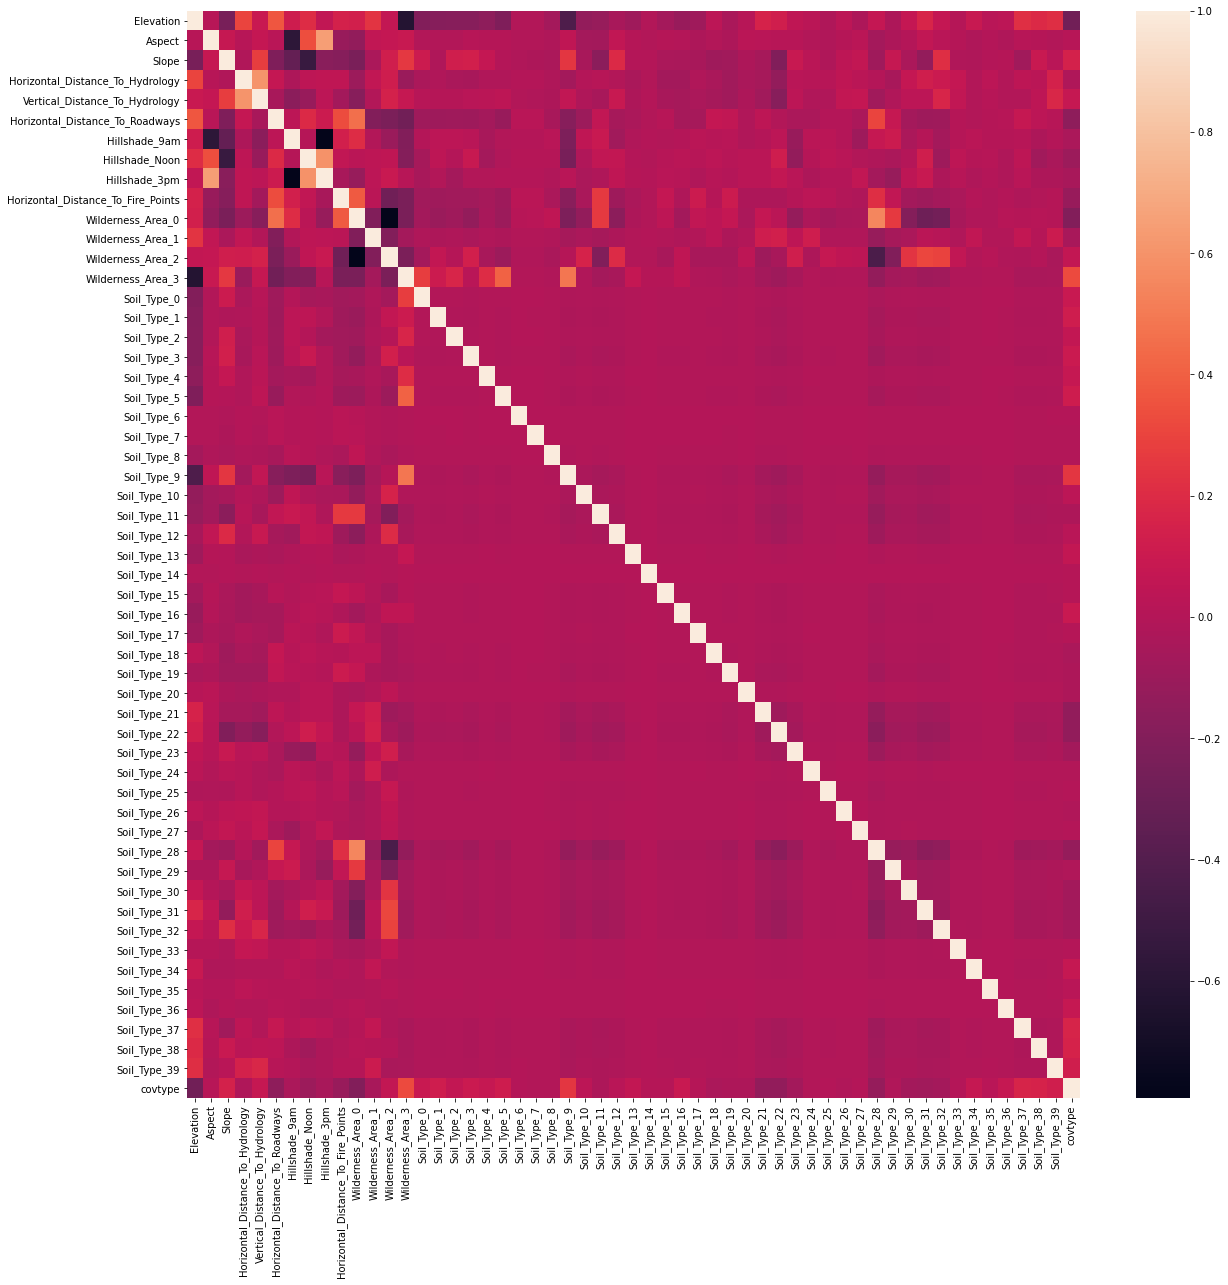

In [5]:
# Построим тепловую карту взаимной корреляции всех признаков (включая целевую переменную)
plt.figure(figsize = (20, 20))
sns.heatmap(df.corr())

По тепловой карте можно сделать вывод, что выраженная корреляция между какими-либо входящими признаками отсутствует.
А также нет какого-либо признака (или нескольких), сильно влияющего на целевую переменную. 
Поэтому нет смысла сразу выкидывать какие-либо признаки из рассмотрения.
Для визуальной оценки наличия выбросов выведем гистограммы по каждому из признаков.

C:\Python\lib\site-packages\pandas\plotting\_matplotlib\core.py:337: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


<Figure size 1440x360 with 0 Axes>

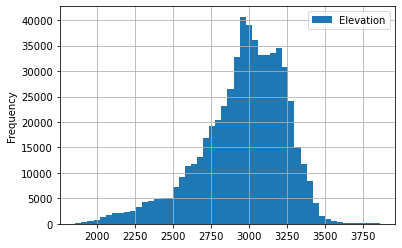

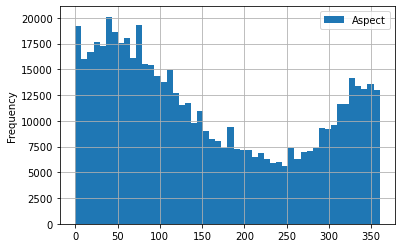

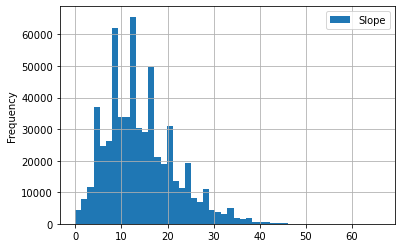

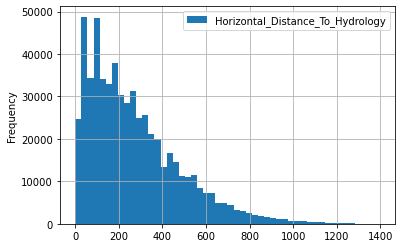

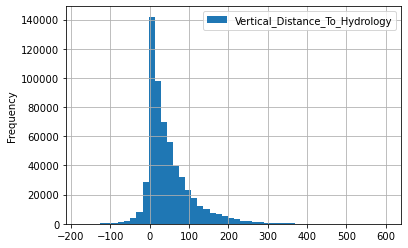

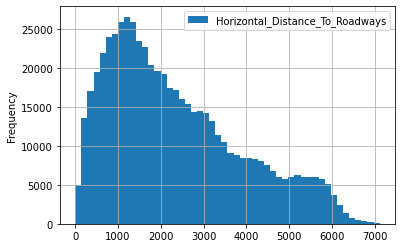

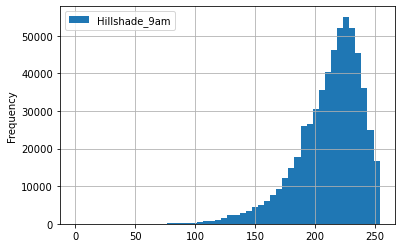

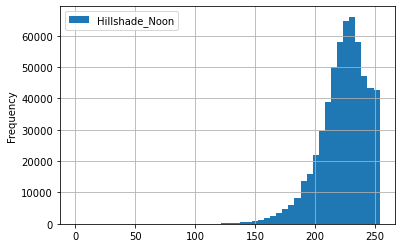

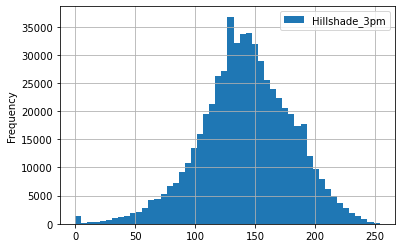

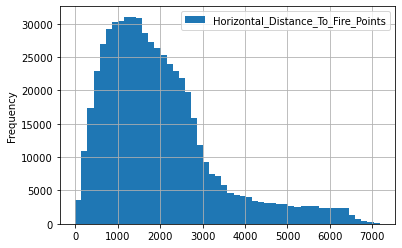

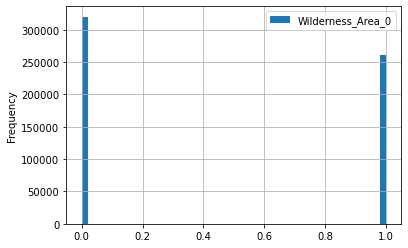

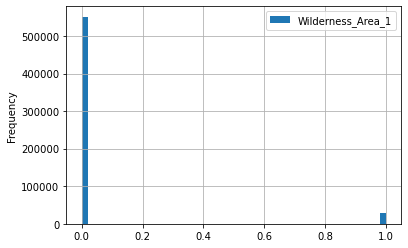

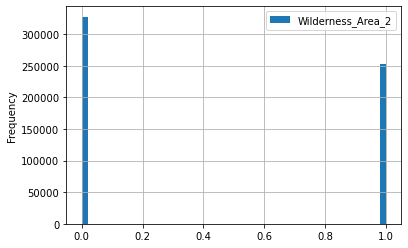

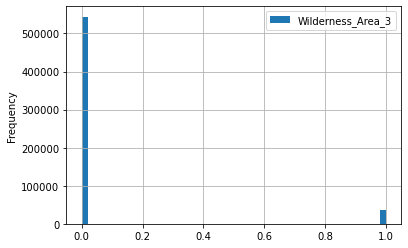

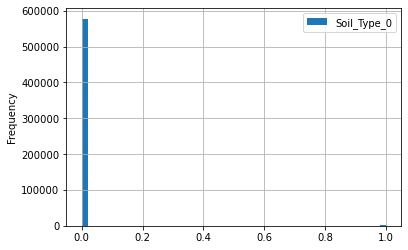

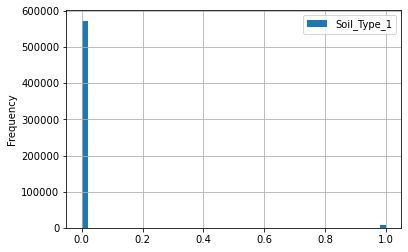

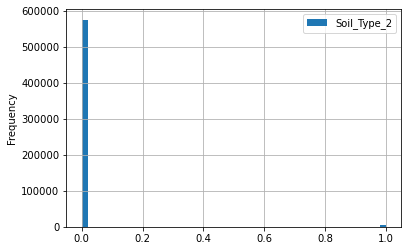

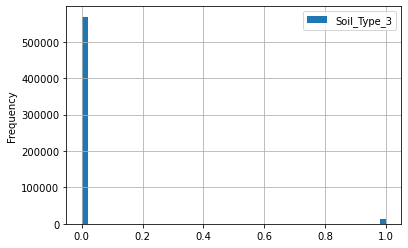

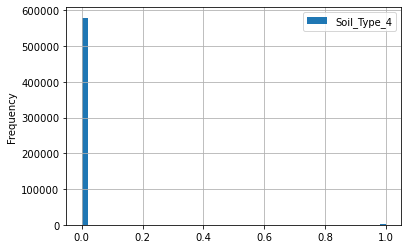

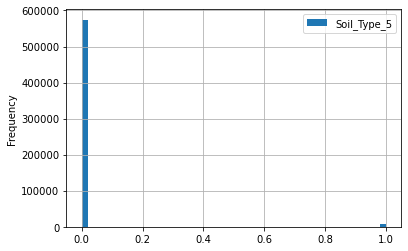

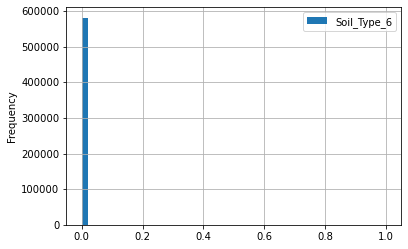

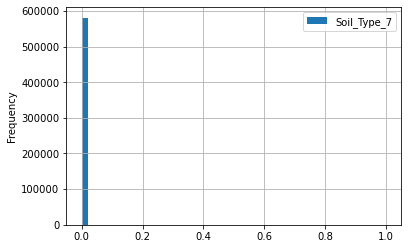

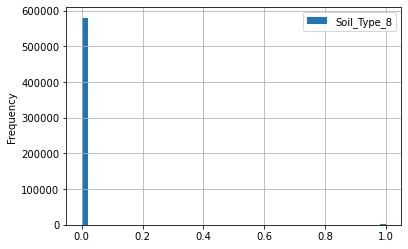

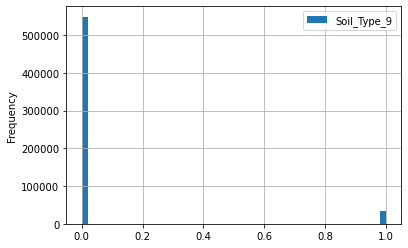

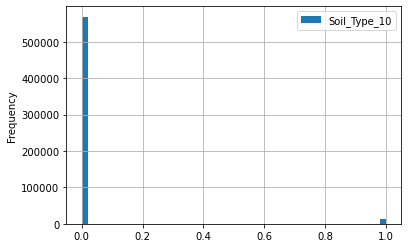

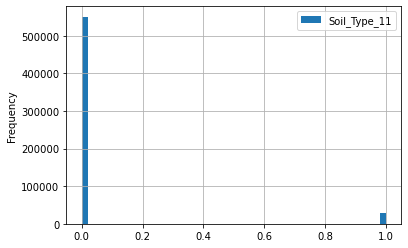

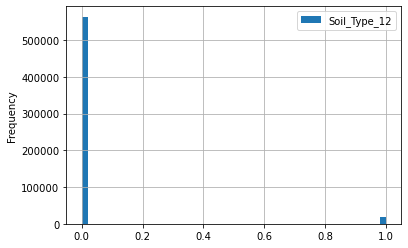

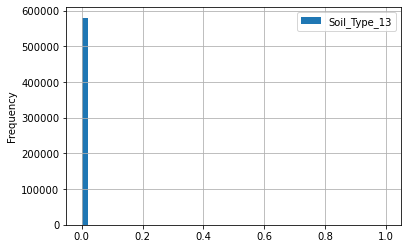

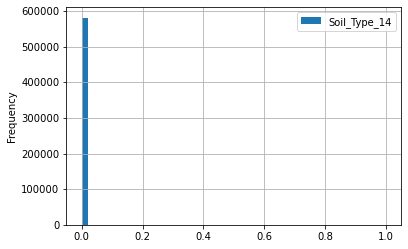

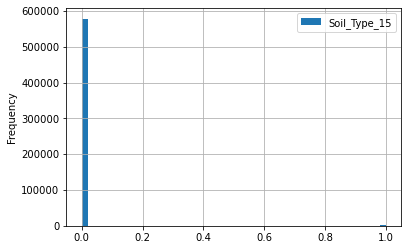

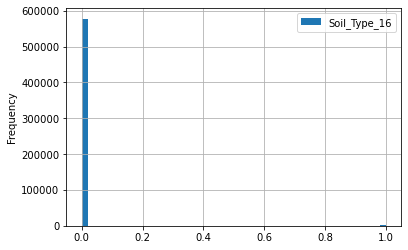

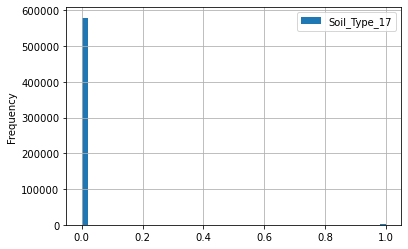

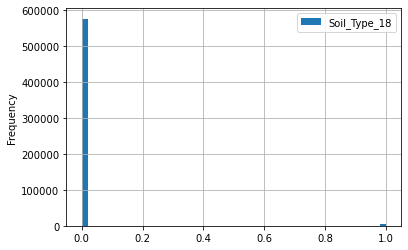

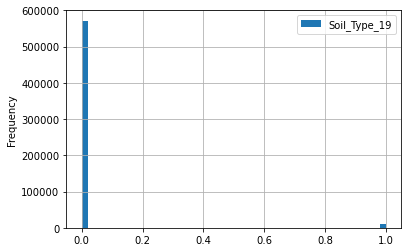

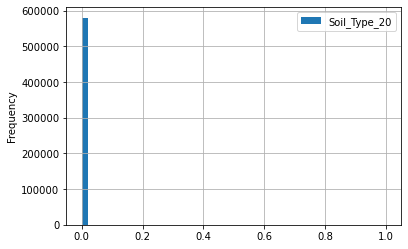

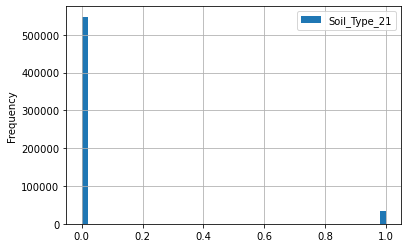

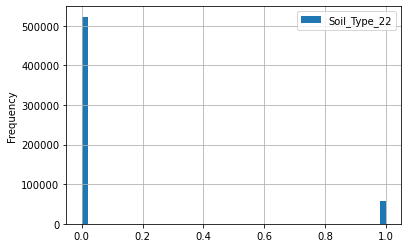

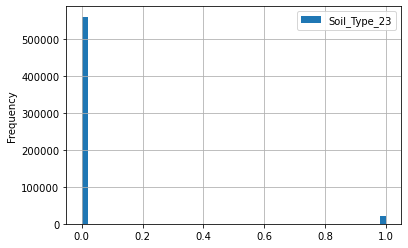

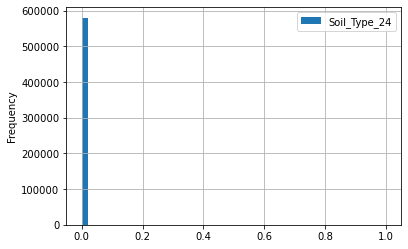

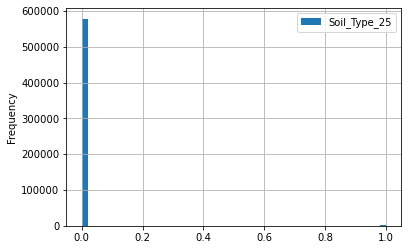

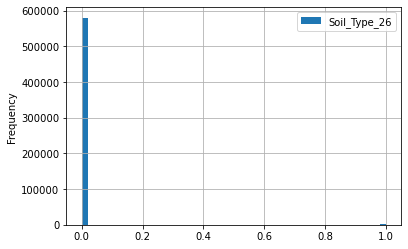

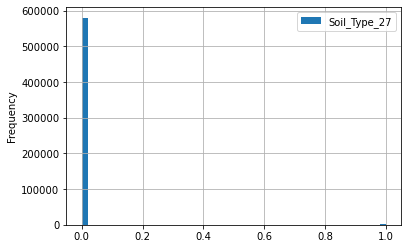

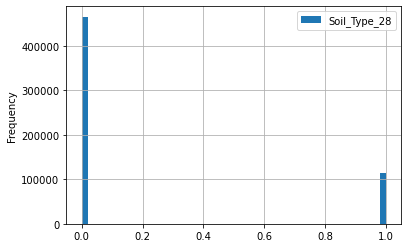

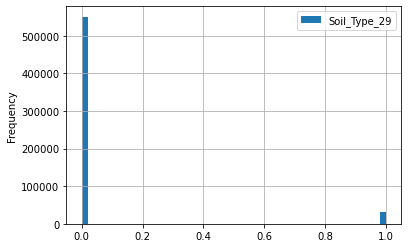

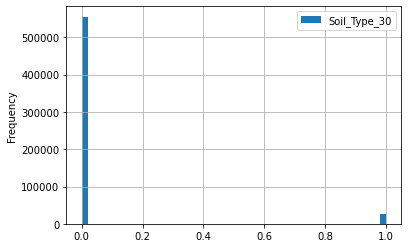

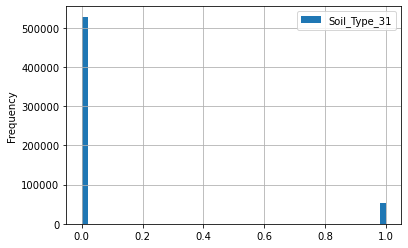

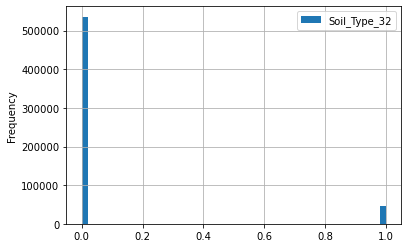

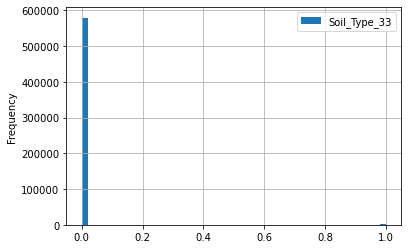

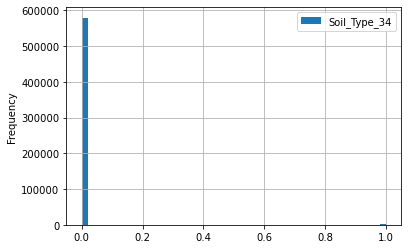

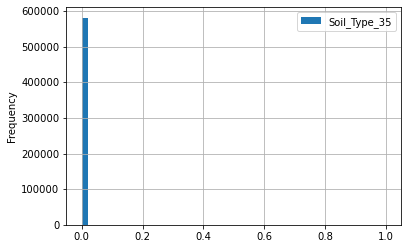

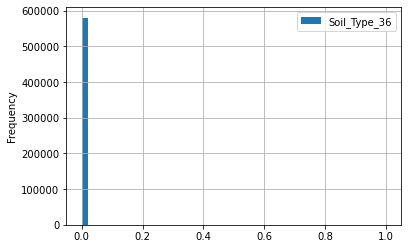

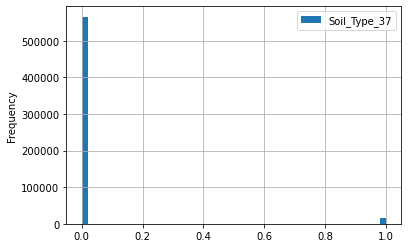

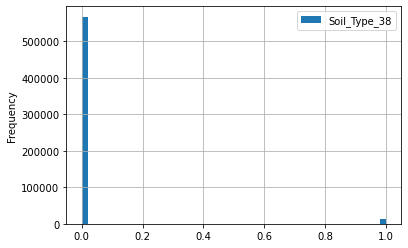

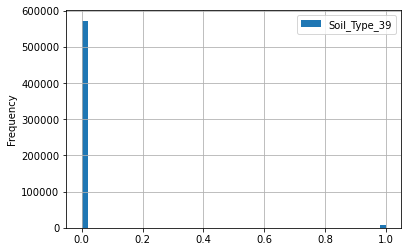

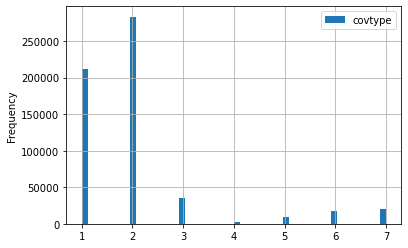

In [6]:
plt.figure(figsize = (20,5))
for i in df.columns:
    df[[i]].plot(kind = 'hist', grid = True, bins = 50)

По гистограммам сложно сделать вывод о наличии выбросов у непрерывных признаков (например, 'Elevation', 'Slope').
Но можно увидеть, что не все непрерывные признаки подчиняются нормальному распределению 
(например, частота признака 'Aspect' изменяется по синусоиде??).

Зато по гистограммам можно сделать вывод об отсутствии выбросов у дискретных признаков, которыми заранее были закодированы категориальные переменные (например, 'Wilderness_Area_', 'Soil_Type_'): единицами закодированы значащие значения ("наличие" признака), нулями - все остальное ("отсутствие" признака). Значения, кроме 0 и 1, отсутствуют. 
Тем не менее, по дискретным признакам выведем количественную оценку уникальных значений, 
чтобы наверняка убедиться в отсутствии ошибочных значений.

In [7]:
cols= ['Wilderness_Area_0',
       'Wilderness_Area_1', 'Wilderness_Area_2', 'Wilderness_Area_3',
       'Soil_Type_0', 'Soil_Type_1', 'Soil_Type_2', 'Soil_Type_3',
       'Soil_Type_4', 'Soil_Type_5', 'Soil_Type_6', 'Soil_Type_7',
       'Soil_Type_8', 'Soil_Type_9', 'Soil_Type_10', 'Soil_Type_11',
       'Soil_Type_12', 'Soil_Type_13', 'Soil_Type_14', 'Soil_Type_15',
       'Soil_Type_16', 'Soil_Type_17', 'Soil_Type_18', 'Soil_Type_19',
       'Soil_Type_20', 'Soil_Type_21', 'Soil_Type_22', 'Soil_Type_23',
       'Soil_Type_24', 'Soil_Type_25', 'Soil_Type_26', 'Soil_Type_27',
       'Soil_Type_28', 'Soil_Type_29', 'Soil_Type_30', 'Soil_Type_31',
       'Soil_Type_32', 'Soil_Type_33', 'Soil_Type_34', 'Soil_Type_35',
       'Soil_Type_36', 'Soil_Type_37', 'Soil_Type_38', 'Soil_Type_39']

for i in cols:
    print(df[i].value_counts())
    print()

0.0    320216
1.0    260796
Name: Wilderness_Area_0, dtype: int64

0.0    551128
1.0     29884
Name: Wilderness_Area_1, dtype: int64

0.0    327648
1.0    253364
Name: Wilderness_Area_2, dtype: int64

0.0    544044
1.0     36968
Name: Wilderness_Area_3, dtype: int64

0.0    577981
1.0      3031
Name: Soil_Type_0, dtype: int64

0.0    573487
1.0      7525
Name: Soil_Type_1, dtype: int64

0.0    576189
1.0      4823
Name: Soil_Type_2, dtype: int64

0.0    568616
1.0     12396
Name: Soil_Type_3, dtype: int64

0.0    579415
1.0      1597
Name: Soil_Type_4, dtype: int64

0.0    574437
1.0      6575
Name: Soil_Type_5, dtype: int64

0.0    580907
1.0       105
Name: Soil_Type_6, dtype: int64

0.0    580833
1.0       179
Name: Soil_Type_7, dtype: int64

0.0    579865
1.0      1147
Name: Soil_Type_8, dtype: int64

0.0    548378
1.0     32634
Name: Soil_Type_9, dtype: int64

0.0    568602
1.0     12410
Name: Soil_Type_10, dtype: int64

0.0    551041
1.0     29971
Name: Soil_Type_11, dtype: int64

Убедились, что по дискретным признакам выбросов нет. Для количественной оценки наличия выбросов по непрерывным признакам 
попробуем вывести количество пограничных значений по каждому из них.

In [8]:
cols= ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points']

for i in cols:
    lower_bound = df[i].quantile(q=0.01)
    upper_bound = df[i].quantile(q=0.99)
    df_ = df[(df[i] < lower_bound) | (df[i] > upper_bound)]
    print(i, df_.shape[0], df.shape[0], round(df_.shape[0]/df.shape[0], 6))

Elevation 11568 581012 0.01991
Aspect 9981 581012 0.017179
Slope 9786 581012 0.016843
Horizontal_Distance_To_Hydrology 5784 581012 0.009955
Vertical_Distance_To_Hydrology 11496 581012 0.019786
Horizontal_Distance_To_Roadways 10764 581012 0.018526
Hillshade_9am 9847 581012 0.016948
Hillshade_Noon 5782 581012 0.009952
Hillshade_3pm 11370 581012 0.019569
Horizontal_Distance_To_Fire_Points 11516 581012 0.019821


In [9]:
# Для примера выведем значения потенциальных выбросов по признаку Elevation 
lower_bound = df['Elevation'].quantile(q=0.01)
upper_bound = df['Elevation'].quantile(q=0.99)
df[(df['Elevation'] < lower_bound) | (df['Elevation'] > upper_bound)]

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type_31,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39,covtype
1820,2011.0,344.0,17.0,313.0,29.0,404.0,183.0,211.0,164.0,300.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
1824,2022.0,24.0,13.0,391.0,42.0,509.0,212.0,212.0,134.0,421.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
1825,2038.0,50.0,17.0,408.0,71.0,474.0,226.0,200.0,102.0,283.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
1827,2018.0,341.0,27.0,351.0,34.0,390.0,152.0,188.0,168.0,190.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
1837,2074.0,348.0,18.0,499.0,107.0,566.0,183.0,208.0,161.0,277.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
551816,3441.0,221.0,10.0,571.0,-11.0,1487.0,207.0,250.0,178.0,3866.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1
551817,3444.0,184.0,8.0,573.0,-8.0,1468.0,222.0,245.0,157.0,3872.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1
551818,3442.0,150.0,9.0,577.0,-10.0,1448.0,232.0,240.0,139.0,3879.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1
551819,3439.0,156.0,9.0,582.0,-13.0,1429.0,231.0,241.0,142.0,3886.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1


Непохоже, что найденные выбросы являются ошибочными значениями, подлежащими исправлению. 
Например, признак 'Elevation': насколько я понимаю, это высота конкретного участка, по которому были собраны параметры. 
Отклонения отражают, соответственно, что часть участков расположена относительно низко/высоко от большинства других.

Теперь обучим модель на количестве признаков от одного до максимально возможного. Применим логистическую регрессию.

In [54]:
# создадим список результатов для накопления оценок по разным вариантам обучения
score_results = []

# создадим и обучим модель регрессии,
# изменяя кол-во признаков от одного до макс.возможного :
full_list = ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area_0',
       'Wilderness_Area_1', 'Wilderness_Area_2', 'Wilderness_Area_3',
       'Soil_Type_0', 'Soil_Type_1', 'Soil_Type_2', 'Soil_Type_3',
       'Soil_Type_4', 'Soil_Type_5', 'Soil_Type_6', 'Soil_Type_7',
       'Soil_Type_8', 'Soil_Type_9', 'Soil_Type_10', 'Soil_Type_11',
       'Soil_Type_12', 'Soil_Type_13', 'Soil_Type_14', 'Soil_Type_15',
       'Soil_Type_16', 'Soil_Type_17', 'Soil_Type_18', 'Soil_Type_19',
       'Soil_Type_20', 'Soil_Type_21', 'Soil_Type_22', 'Soil_Type_23',
       'Soil_Type_24', 'Soil_Type_25', 'Soil_Type_26', 'Soil_Type_27',
       'Soil_Type_28', 'Soil_Type_29', 'Soil_Type_30', 'Soil_Type_31',
       'Soil_Type_32', 'Soil_Type_33', 'Soil_Type_34', 'Soil_Type_35',
       'Soil_Type_36', 'Soil_Type_37', 'Soil_Type_38', 'Soil_Type_39']

y = df['covtype']

cur_list = []

# последовательно будем добавлять по одному признаку из общего списка и повторно обучать модель
for i in range(len(full_list)):
    cur_list.append(full_list[i])
           
# Воспользуемся моделью логистической регрессии, т.к. линейная регрессия, хотя и рассчитывалась быстро, 
# всё же показала очень низкий коэфф-т детерминации 
# (от 0.07492833059692428 на первом признаке до 0.31641067058782324 на всех признаках).
# Вариант с линейной регрессией не стал оставлять в ноутбуке.
    model = LogisticRegression(max_iter=200) # по умолчанию max_iter=100
    X_train, X_test, y_train, y_test = train_test_split(df[cur_list], y, test_size=0.3, random_state=42)
    model.fit(X_train, y_train)

    # коэфф-т детерминации на тестовой выборке
    score = model.score(X_test, y_test)
    score_results.append(score)
    print("Текущий набор признаков:", cur_list)
    print("Коэффициент детерминации на текущем наборе признаков:", score)
    print("=========")

Текущий набор признаков: ['Elevation']
Коэффициент детерминации на текущем наборе признаков: 0.4881012483936112


C:\Python\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Текущий набор признаков: ['Elevation', 'Aspect']
Коэффициент детерминации на текущем наборе признаков: 0.4881012483936112


C:\Python\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Текущий набор признаков: ['Elevation', 'Aspect', 'Slope']
Коэффициент детерминации на текущем наборе признаков: 0.48032747383881036


C:\Python\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Текущий набор признаков: ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology']
Коэффициент детерминации на текущем наборе признаков: 0.4918590508536809


C:\Python\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Текущий набор признаков: ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology']
Коэффициент детерминации на текущем наборе признаков: 0.4968159078391775


C:\Python\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Текущий набор признаков: ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways']
Коэффициент детерминации на текущем наборе признаков: 0.5003212777675785


C:\Python\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Текущий набор признаков: ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am']
Коэффициент детерминации на текущем наборе признаков: 0.5878924178446852


C:\Python\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Текущий набор признаков: ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon']
Коэффициент детерминации на текущем наборе признаков: 0.6327164035248761


C:\Python\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Текущий набор признаков: ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm']
Коэффициент детерминации на текущем наборе признаков: 0.6511038186157518


C:\Python\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Текущий набор признаков: ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points']
Коэффициент детерминации на текущем наборе признаков: 0.6448962731778961


C:\Python\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Текущий набор признаков: ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area_0']
Коэффициент детерминации на текущем наборе признаков: 0.6444258307325134


C:\Python\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Текущий набор признаков: ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area_0', 'Wilderness_Area_1']
Коэффициент детерминации на текущем наборе признаков: 0.646410868367909


C:\Python\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Текущий набор признаков: ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area_0', 'Wilderness_Area_1', 'Wilderness_Area_2']
Коэффициент детерминации на текущем наборе признаков: 0.6492966311731229


C:\Python\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Текущий набор признаков: ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area_0', 'Wilderness_Area_1', 'Wilderness_Area_2', 'Wilderness_Area_3']
Коэффициент детерминации на текущем наборе признаков: 0.6455675142280154


C:\Python\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Текущий набор признаков: ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area_0', 'Wilderness_Area_1', 'Wilderness_Area_2', 'Wilderness_Area_3', 'Soil_Type_0']
Коэффициент детерминации на текущем наборе признаков: 0.6459691114374885


C:\Python\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Текущий набор признаков: ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area_0', 'Wilderness_Area_1', 'Wilderness_Area_2', 'Wilderness_Area_3', 'Soil_Type_0', 'Soil_Type_1']
Коэффициент детерминации на текущем наборе признаков: 0.6445577841013402


C:\Python\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Текущий набор признаков: ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area_0', 'Wilderness_Area_1', 'Wilderness_Area_2', 'Wilderness_Area_3', 'Soil_Type_0', 'Soil_Type_1', 'Soil_Type_2']
Коэффициент детерминации на текущем наборе признаков: 0.6464395538828713


C:\Python\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Текущий набор признаков: ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area_0', 'Wilderness_Area_1', 'Wilderness_Area_2', 'Wilderness_Area_3', 'Soil_Type_0', 'Soil_Type_1', 'Soil_Type_2', 'Soil_Type_3']
Коэффициент детерминации на текущем наборе признаков: 0.6470534239030659


C:\Python\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Текущий набор признаков: ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area_0', 'Wilderness_Area_1', 'Wilderness_Area_2', 'Wilderness_Area_3', 'Soil_Type_0', 'Soil_Type_1', 'Soil_Type_2', 'Soil_Type_3', 'Soil_Type_4']
Коэффициент детерминации на текущем наборе признаков: 0.645659307875895


C:\Python\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Текущий набор признаков: ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area_0', 'Wilderness_Area_1', 'Wilderness_Area_2', 'Wilderness_Area_3', 'Soil_Type_0', 'Soil_Type_1', 'Soil_Type_2', 'Soil_Type_3', 'Soil_Type_4', 'Soil_Type_5']
Коэффициент детерминации на текущем наборе признаков: 0.6439783366991004


C:\Python\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Текущий набор признаков: ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area_0', 'Wilderness_Area_1', 'Wilderness_Area_2', 'Wilderness_Area_3', 'Soil_Type_0', 'Soil_Type_1', 'Soil_Type_2', 'Soil_Type_3', 'Soil_Type_4', 'Soil_Type_5', 'Soil_Type_6']
Коэффициент детерминации на текущем наборе признаков: 0.6490212502294841


C:\Python\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Текущий набор признаков: ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area_0', 'Wilderness_Area_1', 'Wilderness_Area_2', 'Wilderness_Area_3', 'Soil_Type_0', 'Soil_Type_1', 'Soil_Type_2', 'Soil_Type_3', 'Soil_Type_4', 'Soil_Type_5', 'Soil_Type_6', 'Soil_Type_7']
Коэффициент детерминации на текущем наборе признаков: 0.6465198733247659


C:\Python\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Текущий набор признаков: ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area_0', 'Wilderness_Area_1', 'Wilderness_Area_2', 'Wilderness_Area_3', 'Soil_Type_0', 'Soil_Type_1', 'Soil_Type_2', 'Soil_Type_3', 'Soil_Type_4', 'Soil_Type_5', 'Soil_Type_6', 'Soil_Type_7', 'Soil_Type_8']
Коэффициент детерминации на текущем наборе признаков: 0.6447069487791445


C:\Python\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Текущий набор признаков: ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area_0', 'Wilderness_Area_1', 'Wilderness_Area_2', 'Wilderness_Area_3', 'Soil_Type_0', 'Soil_Type_1', 'Soil_Type_2', 'Soil_Type_3', 'Soil_Type_4', 'Soil_Type_5', 'Soil_Type_6', 'Soil_Type_7', 'Soil_Type_8', 'Soil_Type_9']
Коэффициент детерминации на текущем наборе признаков: 0.6462100697631724


C:\Python\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Текущий набор признаков: ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area_0', 'Wilderness_Area_1', 'Wilderness_Area_2', 'Wilderness_Area_3', 'Soil_Type_0', 'Soil_Type_1', 'Soil_Type_2', 'Soil_Type_3', 'Soil_Type_4', 'Soil_Type_5', 'Soil_Type_6', 'Soil_Type_7', 'Soil_Type_8', 'Soil_Type_9', 'Soil_Type_10']
Коэффициент детерминации на текущем наборе признаков: 0.6461641729392326


C:\Python\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Текущий набор признаков: ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area_0', 'Wilderness_Area_1', 'Wilderness_Area_2', 'Wilderness_Area_3', 'Soil_Type_0', 'Soil_Type_1', 'Soil_Type_2', 'Soil_Type_3', 'Soil_Type_4', 'Soil_Type_5', 'Soil_Type_6', 'Soil_Type_7', 'Soil_Type_8', 'Soil_Type_9', 'Soil_Type_10', 'Soil_Type_11']
Коэффициент детерминации на текущем наборе признаков: 0.6449020102808886


C:\Python\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Текущий набор признаков: ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area_0', 'Wilderness_Area_1', 'Wilderness_Area_2', 'Wilderness_Area_3', 'Soil_Type_0', 'Soil_Type_1', 'Soil_Type_2', 'Soil_Type_3', 'Soil_Type_4', 'Soil_Type_5', 'Soil_Type_6', 'Soil_Type_7', 'Soil_Type_8', 'Soil_Type_9', 'Soil_Type_10', 'Soil_Type_11', 'Soil_Type_12']
Коэффициент детерминации на текущем наборе признаков: 0.6454986689921057


C:\Python\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Текущий набор признаков: ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area_0', 'Wilderness_Area_1', 'Wilderness_Area_2', 'Wilderness_Area_3', 'Soil_Type_0', 'Soil_Type_1', 'Soil_Type_2', 'Soil_Type_3', 'Soil_Type_4', 'Soil_Type_5', 'Soil_Type_6', 'Soil_Type_7', 'Soil_Type_8', 'Soil_Type_9', 'Soil_Type_10', 'Soil_Type_11', 'Soil_Type_12', 'Soil_Type_13']
Коэффициент детерминации на текущем наборе признаков: 0.6452691848724068


C:\Python\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Текущий набор признаков: ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area_0', 'Wilderness_Area_1', 'Wilderness_Area_2', 'Wilderness_Area_3', 'Soil_Type_0', 'Soil_Type_1', 'Soil_Type_2', 'Soil_Type_3', 'Soil_Type_4', 'Soil_Type_5', 'Soil_Type_6', 'Soil_Type_7', 'Soil_Type_8', 'Soil_Type_9', 'Soil_Type_10', 'Soil_Type_11', 'Soil_Type_12', 'Soil_Type_13', 'Soil_Type_14']
Коэффициент детерминации на текущем наборе признаков: 0.6462846521020745


C:\Python\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Текущий набор признаков: ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area_0', 'Wilderness_Area_1', 'Wilderness_Area_2', 'Wilderness_Area_3', 'Soil_Type_0', 'Soil_Type_1', 'Soil_Type_2', 'Soil_Type_3', 'Soil_Type_4', 'Soil_Type_5', 'Soil_Type_6', 'Soil_Type_7', 'Soil_Type_8', 'Soil_Type_9', 'Soil_Type_10', 'Soil_Type_11', 'Soil_Type_12', 'Soil_Type_13', 'Soil_Type_14', 'Soil_Type_15']
Коэффициент детерминации на текущем наборе признаков: 0.6464166054709014


C:\Python\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Текущий набор признаков: ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area_0', 'Wilderness_Area_1', 'Wilderness_Area_2', 'Wilderness_Area_3', 'Soil_Type_0', 'Soil_Type_1', 'Soil_Type_2', 'Soil_Type_3', 'Soil_Type_4', 'Soil_Type_5', 'Soil_Type_6', 'Soil_Type_7', 'Soil_Type_8', 'Soil_Type_9', 'Soil_Type_10', 'Soil_Type_11', 'Soil_Type_12', 'Soil_Type_13', 'Soil_Type_14', 'Soil_Type_15', 'Soil_Type_16']
Коэффициент детерминации на текущем наборе признаков: 0.6471796401689003


C:\Python\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Текущий набор признаков: ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area_0', 'Wilderness_Area_1', 'Wilderness_Area_2', 'Wilderness_Area_3', 'Soil_Type_0', 'Soil_Type_1', 'Soil_Type_2', 'Soil_Type_3', 'Soil_Type_4', 'Soil_Type_5', 'Soil_Type_6', 'Soil_Type_7', 'Soil_Type_8', 'Soil_Type_9', 'Soil_Type_10', 'Soil_Type_11', 'Soil_Type_12', 'Soil_Type_13', 'Soil_Type_14', 'Soil_Type_15', 'Soil_Type_16', 'Soil_Type_17']
Коэффициент детерминации на текущем наборе признаков: 0.6454240866532036


C:\Python\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Текущий набор признаков: ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area_0', 'Wilderness_Area_1', 'Wilderness_Area_2', 'Wilderness_Area_3', 'Soil_Type_0', 'Soil_Type_1', 'Soil_Type_2', 'Soil_Type_3', 'Soil_Type_4', 'Soil_Type_5', 'Soil_Type_6', 'Soil_Type_7', 'Soil_Type_8', 'Soil_Type_9', 'Soil_Type_10', 'Soil_Type_11', 'Soil_Type_12', 'Soil_Type_13', 'Soil_Type_14', 'Soil_Type_15', 'Soil_Type_16', 'Soil_Type_17', 'Soil_Type_18']
Коэффициент детерминации на текущем наборе признаков: 0.6479598861758766


C:\Python\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Текущий набор признаков: ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area_0', 'Wilderness_Area_1', 'Wilderness_Area_2', 'Wilderness_Area_3', 'Soil_Type_0', 'Soil_Type_1', 'Soil_Type_2', 'Soil_Type_3', 'Soil_Type_4', 'Soil_Type_5', 'Soil_Type_6', 'Soil_Type_7', 'Soil_Type_8', 'Soil_Type_9', 'Soil_Type_10', 'Soil_Type_11', 'Soil_Type_12', 'Soil_Type_13', 'Soil_Type_14', 'Soil_Type_15', 'Soil_Type_16', 'Soil_Type_17', 'Soil_Type_18', 'Soil_Type_19']
Коэффициент детерминации на текущем наборе признаков: 0.6445348356893703


C:\Python\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Текущий набор признаков: ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area_0', 'Wilderness_Area_1', 'Wilderness_Area_2', 'Wilderness_Area_3', 'Soil_Type_0', 'Soil_Type_1', 'Soil_Type_2', 'Soil_Type_3', 'Soil_Type_4', 'Soil_Type_5', 'Soil_Type_6', 'Soil_Type_7', 'Soil_Type_8', 'Soil_Type_9', 'Soil_Type_10', 'Soil_Type_11', 'Soil_Type_12', 'Soil_Type_13', 'Soil_Type_14', 'Soil_Type_15', 'Soil_Type_16', 'Soil_Type_17', 'Soil_Type_18', 'Soil_Type_19', 'Soil_Type_20']
Коэффициент детерминации на текущем наборе признаков: 0.6459002662015788


C:\Python\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Текущий набор признаков: ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area_0', 'Wilderness_Area_1', 'Wilderness_Area_2', 'Wilderness_Area_3', 'Soil_Type_0', 'Soil_Type_1', 'Soil_Type_2', 'Soil_Type_3', 'Soil_Type_4', 'Soil_Type_5', 'Soil_Type_6', 'Soil_Type_7', 'Soil_Type_8', 'Soil_Type_9', 'Soil_Type_10', 'Soil_Type_11', 'Soil_Type_12', 'Soil_Type_13', 'Soil_Type_14', 'Soil_Type_15', 'Soil_Type_16', 'Soil_Type_17', 'Soil_Type_18', 'Soil_Type_19', 'Soil_Type_20', 'Soil_Type_21']
Коэффициент детерминации на текущем наборе признаков: 0.6500539287681293


C:\Python\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Текущий набор признаков: ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area_0', 'Wilderness_Area_1', 'Wilderness_Area_2', 'Wilderness_Area_3', 'Soil_Type_0', 'Soil_Type_1', 'Soil_Type_2', 'Soil_Type_3', 'Soil_Type_4', 'Soil_Type_5', 'Soil_Type_6', 'Soil_Type_7', 'Soil_Type_8', 'Soil_Type_9', 'Soil_Type_10', 'Soil_Type_11', 'Soil_Type_12', 'Soil_Type_13', 'Soil_Type_14', 'Soil_Type_15', 'Soil_Type_16', 'Soil_Type_17', 'Soil_Type_18', 'Soil_Type_19', 'Soil_Type_20', 'Soil_Type_21', 'Soil_Type_22']
Коэффициент детерминации на текущем наборе признаков: 0.6482237929135304


C:\Python\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Текущий набор признаков: ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area_0', 'Wilderness_Area_1', 'Wilderness_Area_2', 'Wilderness_Area_3', 'Soil_Type_0', 'Soil_Type_1', 'Soil_Type_2', 'Soil_Type_3', 'Soil_Type_4', 'Soil_Type_5', 'Soil_Type_6', 'Soil_Type_7', 'Soil_Type_8', 'Soil_Type_9', 'Soil_Type_10', 'Soil_Type_11', 'Soil_Type_12', 'Soil_Type_13', 'Soil_Type_14', 'Soil_Type_15', 'Soil_Type_16', 'Soil_Type_17', 'Soil_Type_18', 'Soil_Type_19', 'Soil_Type_20', 'Soil_Type_21', 'Soil_Type_22', 'Soil_Type_23']
Коэффициент детерминации на текущем наборе признаков: 0.6466346153846154


C:\Python\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Текущий набор признаков: ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area_0', 'Wilderness_Area_1', 'Wilderness_Area_2', 'Wilderness_Area_3', 'Soil_Type_0', 'Soil_Type_1', 'Soil_Type_2', 'Soil_Type_3', 'Soil_Type_4', 'Soil_Type_5', 'Soil_Type_6', 'Soil_Type_7', 'Soil_Type_8', 'Soil_Type_9', 'Soil_Type_10', 'Soil_Type_11', 'Soil_Type_12', 'Soil_Type_13', 'Soil_Type_14', 'Soil_Type_15', 'Soil_Type_16', 'Soil_Type_17', 'Soil_Type_18', 'Soil_Type_19', 'Soil_Type_20', 'Soil_Type_21', 'Soil_Type_22', 'Soil_Type_23', 'Soil_Type_24']
Коэффициент детерминации на текущем наборе признаков: 0.6462444923811272


C:\Python\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Текущий набор признаков: ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area_0', 'Wilderness_Area_1', 'Wilderness_Area_2', 'Wilderness_Area_3', 'Soil_Type_0', 'Soil_Type_1', 'Soil_Type_2', 'Soil_Type_3', 'Soil_Type_4', 'Soil_Type_5', 'Soil_Type_6', 'Soil_Type_7', 'Soil_Type_8', 'Soil_Type_9', 'Soil_Type_10', 'Soil_Type_11', 'Soil_Type_12', 'Soil_Type_13', 'Soil_Type_14', 'Soil_Type_15', 'Soil_Type_16', 'Soil_Type_17', 'Soil_Type_18', 'Soil_Type_19', 'Soil_Type_20', 'Soil_Type_21', 'Soil_Type_22', 'Soil_Type_23', 'Soil_Type_24', 'Soil_Type_25']
Коэффициент детерминации на текущем наборе признаков: 0.6443799339085735


C:\Python\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Текущий набор признаков: ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area_0', 'Wilderness_Area_1', 'Wilderness_Area_2', 'Wilderness_Area_3', 'Soil_Type_0', 'Soil_Type_1', 'Soil_Type_2', 'Soil_Type_3', 'Soil_Type_4', 'Soil_Type_5', 'Soil_Type_6', 'Soil_Type_7', 'Soil_Type_8', 'Soil_Type_9', 'Soil_Type_10', 'Soil_Type_11', 'Soil_Type_12', 'Soil_Type_13', 'Soil_Type_14', 'Soil_Type_15', 'Soil_Type_16', 'Soil_Type_17', 'Soil_Type_18', 'Soil_Type_19', 'Soil_Type_20', 'Soil_Type_21', 'Soil_Type_22', 'Soil_Type_23', 'Soil_Type_24', 'Soil_Type_25', 'Soil_Type_26']
Коэффициент детерминации на текущем наборе признаков: 0.6461526987332477


C:\Python\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Текущий набор признаков: ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area_0', 'Wilderness_Area_1', 'Wilderness_Area_2', 'Wilderness_Area_3', 'Soil_Type_0', 'Soil_Type_1', 'Soil_Type_2', 'Soil_Type_3', 'Soil_Type_4', 'Soil_Type_5', 'Soil_Type_6', 'Soil_Type_7', 'Soil_Type_8', 'Soil_Type_9', 'Soil_Type_10', 'Soil_Type_11', 'Soil_Type_12', 'Soil_Type_13', 'Soil_Type_14', 'Soil_Type_15', 'Soil_Type_16', 'Soil_Type_17', 'Soil_Type_18', 'Soil_Type_19', 'Soil_Type_20', 'Soil_Type_21', 'Soil_Type_22', 'Soil_Type_23', 'Soil_Type_24', 'Soil_Type_25', 'Soil_Type_26', 'Soil_Type_27']
Коэффициент детерминации на текущем наборе признаков: 0.6461641729392326


C:\Python\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Текущий набор признаков: ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area_0', 'Wilderness_Area_1', 'Wilderness_Area_2', 'Wilderness_Area_3', 'Soil_Type_0', 'Soil_Type_1', 'Soil_Type_2', 'Soil_Type_3', 'Soil_Type_4', 'Soil_Type_5', 'Soil_Type_6', 'Soil_Type_7', 'Soil_Type_8', 'Soil_Type_9', 'Soil_Type_10', 'Soil_Type_11', 'Soil_Type_12', 'Soil_Type_13', 'Soil_Type_14', 'Soil_Type_15', 'Soil_Type_16', 'Soil_Type_17', 'Soil_Type_18', 'Soil_Type_19', 'Soil_Type_20', 'Soil_Type_21', 'Soil_Type_22', 'Soil_Type_23', 'Soil_Type_24', 'Soil_Type_25', 'Soil_Type_26', 'Soil_Type_27', 'Soil_Type_28']
Коэффициент детерминации на текущем наборе признаков: 0.6455789884340004


C:\Python\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Текущий набор признаков: ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area_0', 'Wilderness_Area_1', 'Wilderness_Area_2', 'Wilderness_Area_3', 'Soil_Type_0', 'Soil_Type_1', 'Soil_Type_2', 'Soil_Type_3', 'Soil_Type_4', 'Soil_Type_5', 'Soil_Type_6', 'Soil_Type_7', 'Soil_Type_8', 'Soil_Type_9', 'Soil_Type_10', 'Soil_Type_11', 'Soil_Type_12', 'Soil_Type_13', 'Soil_Type_14', 'Soil_Type_15', 'Soil_Type_16', 'Soil_Type_17', 'Soil_Type_18', 'Soil_Type_19', 'Soil_Type_20', 'Soil_Type_21', 'Soil_Type_22', 'Soil_Type_23', 'Soil_Type_24', 'Soil_Type_25', 'Soil_Type_26', 'Soil_Type_27', 'Soil_Type_28', 'Soil_Type_29']
Коэффициент детерминации на текущем наборе признаков: 0.6450110152377455


C:\Python\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Текущий набор признаков: ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area_0', 'Wilderness_Area_1', 'Wilderness_Area_2', 'Wilderness_Area_3', 'Soil_Type_0', 'Soil_Type_1', 'Soil_Type_2', 'Soil_Type_3', 'Soil_Type_4', 'Soil_Type_5', 'Soil_Type_6', 'Soil_Type_7', 'Soil_Type_8', 'Soil_Type_9', 'Soil_Type_10', 'Soil_Type_11', 'Soil_Type_12', 'Soil_Type_13', 'Soil_Type_14', 'Soil_Type_15', 'Soil_Type_16', 'Soil_Type_17', 'Soil_Type_18', 'Soil_Type_19', 'Soil_Type_20', 'Soil_Type_21', 'Soil_Type_22', 'Soil_Type_23', 'Soil_Type_24', 'Soil_Type_25', 'Soil_Type_26', 'Soil_Type_27', 'Soil_Type_28', 'Soil_Type_29', 'Soil_Type_30']
Коэффициент детерминации на текущем наборе признаков: 0.6480115201028089


C:\Python\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Текущий набор признаков: ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area_0', 'Wilderness_Area_1', 'Wilderness_Area_2', 'Wilderness_Area_3', 'Soil_Type_0', 'Soil_Type_1', 'Soil_Type_2', 'Soil_Type_3', 'Soil_Type_4', 'Soil_Type_5', 'Soil_Type_6', 'Soil_Type_7', 'Soil_Type_8', 'Soil_Type_9', 'Soil_Type_10', 'Soil_Type_11', 'Soil_Type_12', 'Soil_Type_13', 'Soil_Type_14', 'Soil_Type_15', 'Soil_Type_16', 'Soil_Type_17', 'Soil_Type_18', 'Soil_Type_19', 'Soil_Type_20', 'Soil_Type_21', 'Soil_Type_22', 'Soil_Type_23', 'Soil_Type_24', 'Soil_Type_25', 'Soil_Type_26', 'Soil_Type_27', 'Soil_Type_28', 'Soil_Type_29', 'Soil_Type_30', 'Soil_Type_31']
Коэффициент детерминации на текущем наборе признаков: 0.6442996144666789


C:\Python\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Текущий набор признаков: ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area_0', 'Wilderness_Area_1', 'Wilderness_Area_2', 'Wilderness_Area_3', 'Soil_Type_0', 'Soil_Type_1', 'Soil_Type_2', 'Soil_Type_3', 'Soil_Type_4', 'Soil_Type_5', 'Soil_Type_6', 'Soil_Type_7', 'Soil_Type_8', 'Soil_Type_9', 'Soil_Type_10', 'Soil_Type_11', 'Soil_Type_12', 'Soil_Type_13', 'Soil_Type_14', 'Soil_Type_15', 'Soil_Type_16', 'Soil_Type_17', 'Soil_Type_18', 'Soil_Type_19', 'Soil_Type_20', 'Soil_Type_21', 'Soil_Type_22', 'Soil_Type_23', 'Soil_Type_24', 'Soil_Type_25', 'Soil_Type_26', 'Soil_Type_27', 'Soil_Type_28', 'Soil_Type_29', 'Soil_Type_30', 'Soil_Type_31', 'Soil_Type_32']
Коэффициент детерминации на текущем наборе признаков: 0.6437947494033412


C:\Python\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Текущий набор признаков: ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area_0', 'Wilderness_Area_1', 'Wilderness_Area_2', 'Wilderness_Area_3', 'Soil_Type_0', 'Soil_Type_1', 'Soil_Type_2', 'Soil_Type_3', 'Soil_Type_4', 'Soil_Type_5', 'Soil_Type_6', 'Soil_Type_7', 'Soil_Type_8', 'Soil_Type_9', 'Soil_Type_10', 'Soil_Type_11', 'Soil_Type_12', 'Soil_Type_13', 'Soil_Type_14', 'Soil_Type_15', 'Soil_Type_16', 'Soil_Type_17', 'Soil_Type_18', 'Soil_Type_19', 'Soil_Type_20', 'Soil_Type_21', 'Soil_Type_22', 'Soil_Type_23', 'Soil_Type_24', 'Soil_Type_25', 'Soil_Type_26', 'Soil_Type_27', 'Soil_Type_28', 'Soil_Type_29', 'Soil_Type_30', 'Soil_Type_31', 'Soil_Type_32', 'Soil_Type_33']
Коэффициент детерминации на текущем наборе признаков: 0.6442824031577015


C:\Python\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Текущий набор признаков: ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area_0', 'Wilderness_Area_1', 'Wilderness_Area_2', 'Wilderness_Area_3', 'Soil_Type_0', 'Soil_Type_1', 'Soil_Type_2', 'Soil_Type_3', 'Soil_Type_4', 'Soil_Type_5', 'Soil_Type_6', 'Soil_Type_7', 'Soil_Type_8', 'Soil_Type_9', 'Soil_Type_10', 'Soil_Type_11', 'Soil_Type_12', 'Soil_Type_13', 'Soil_Type_14', 'Soil_Type_15', 'Soil_Type_16', 'Soil_Type_17', 'Soil_Type_18', 'Soil_Type_19', 'Soil_Type_20', 'Soil_Type_21', 'Soil_Type_22', 'Soil_Type_23', 'Soil_Type_24', 'Soil_Type_25', 'Soil_Type_26', 'Soil_Type_27', 'Soil_Type_28', 'Soil_Type_29', 'Soil_Type_30', 'Soil_Type_31', 'Soil_Type_32', 'Soil_Type_33', 'Soil_Type_34']
Коэффициент детерминации на текущем наборе признаков: 0.6447643198090692


C:\Python\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Текущий набор признаков: ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area_0', 'Wilderness_Area_1', 'Wilderness_Area_2', 'Wilderness_Area_3', 'Soil_Type_0', 'Soil_Type_1', 'Soil_Type_2', 'Soil_Type_3', 'Soil_Type_4', 'Soil_Type_5', 'Soil_Type_6', 'Soil_Type_7', 'Soil_Type_8', 'Soil_Type_9', 'Soil_Type_10', 'Soil_Type_11', 'Soil_Type_12', 'Soil_Type_13', 'Soil_Type_14', 'Soil_Type_15', 'Soil_Type_16', 'Soil_Type_17', 'Soil_Type_18', 'Soil_Type_19', 'Soil_Type_20', 'Soil_Type_21', 'Soil_Type_22', 'Soil_Type_23', 'Soil_Type_24', 'Soil_Type_25', 'Soil_Type_26', 'Soil_Type_27', 'Soil_Type_28', 'Soil_Type_29', 'Soil_Type_30', 'Soil_Type_31', 'Soil_Type_32', 'Soil_Type_33', 'Soil_Type_34', 'Soil_Type_35']
Коэффициент детерминации на текущем наборе признаков: 0.6454298237561961


C:\Python\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Текущий набор признаков: ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area_0', 'Wilderness_Area_1', 'Wilderness_Area_2', 'Wilderness_Area_3', 'Soil_Type_0', 'Soil_Type_1', 'Soil_Type_2', 'Soil_Type_3', 'Soil_Type_4', 'Soil_Type_5', 'Soil_Type_6', 'Soil_Type_7', 'Soil_Type_8', 'Soil_Type_9', 'Soil_Type_10', 'Soil_Type_11', 'Soil_Type_12', 'Soil_Type_13', 'Soil_Type_14', 'Soil_Type_15', 'Soil_Type_16', 'Soil_Type_17', 'Soil_Type_18', 'Soil_Type_19', 'Soil_Type_20', 'Soil_Type_21', 'Soil_Type_22', 'Soil_Type_23', 'Soil_Type_24', 'Soil_Type_25', 'Soil_Type_26', 'Soil_Type_27', 'Soil_Type_28', 'Soil_Type_29', 'Soil_Type_30', 'Soil_Type_31', 'Soil_Type_32', 'Soil_Type_33', 'Soil_Type_34', 'Soil_Type_35', 'Soil_Type_36']
Коэффициент детерминации на текущем наборе признаков: 0.6458199467596842


C:\Python\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Текущий набор признаков: ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area_0', 'Wilderness_Area_1', 'Wilderness_Area_2', 'Wilderness_Area_3', 'Soil_Type_0', 'Soil_Type_1', 'Soil_Type_2', 'Soil_Type_3', 'Soil_Type_4', 'Soil_Type_5', 'Soil_Type_6', 'Soil_Type_7', 'Soil_Type_8', 'Soil_Type_9', 'Soil_Type_10', 'Soil_Type_11', 'Soil_Type_12', 'Soil_Type_13', 'Soil_Type_14', 'Soil_Type_15', 'Soil_Type_16', 'Soil_Type_17', 'Soil_Type_18', 'Soil_Type_19', 'Soil_Type_20', 'Soil_Type_21', 'Soil_Type_22', 'Soil_Type_23', 'Soil_Type_24', 'Soil_Type_25', 'Soil_Type_26', 'Soil_Type_27', 'Soil_Type_28', 'Soil_Type_29', 'Soil_Type_30', 'Soil_Type_31', 'Soil_Type_32', 'Soil_Type_33', 'Soil_Type_34', 'Soil_Type_35', 'Soil_Type_36', 'Soil_Type_37']
Коэффициент детерминации на текущем наборе признаков: 0.647173903

C:\Python\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Текущий набор признаков: ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area_0', 'Wilderness_Area_1', 'Wilderness_Area_2', 'Wilderness_Area_3', 'Soil_Type_0', 'Soil_Type_1', 'Soil_Type_2', 'Soil_Type_3', 'Soil_Type_4', 'Soil_Type_5', 'Soil_Type_6', 'Soil_Type_7', 'Soil_Type_8', 'Soil_Type_9', 'Soil_Type_10', 'Soil_Type_11', 'Soil_Type_12', 'Soil_Type_13', 'Soil_Type_14', 'Soil_Type_15', 'Soil_Type_16', 'Soil_Type_17', 'Soil_Type_18', 'Soil_Type_19', 'Soil_Type_20', 'Soil_Type_21', 'Soil_Type_22', 'Soil_Type_23', 'Soil_Type_24', 'Soil_Type_25', 'Soil_Type_26', 'Soil_Type_27', 'Soil_Type_28', 'Soil_Type_29', 'Soil_Type_30', 'Soil_Type_31', 'Soil_Type_32', 'Soil_Type_33', 'Soil_Type_34', 'Soil_Type_35', 'Soil_Type_36', 'Soil_Type_37', 'Soil_Type_38']
Коэффициент детерминации на текущем наборе призна

C:\Python\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


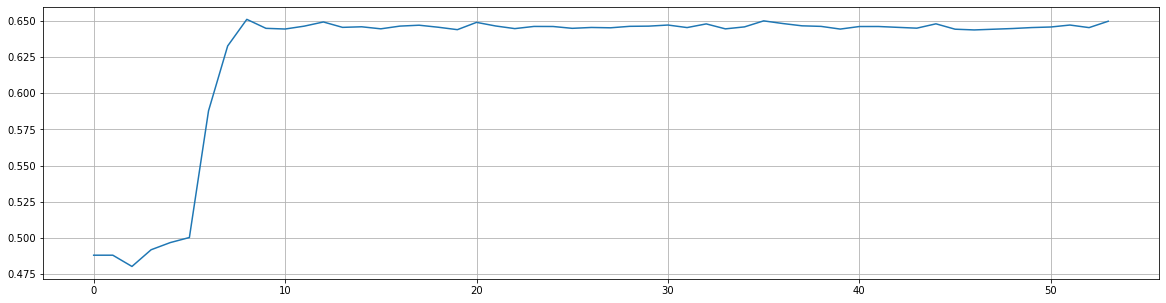

In [55]:
# выведем график значений коэфф-та детерминации, рассчитанного на модели логистической регрессии путем 
# последовательного добавления признаков в модель (без отбора признаков)
plt.figure(figsize=(20, 5))
plt.plot(score_results)
plt.grid()
plt.show()

In [56]:
max(score_results)

0.6511038186157518

Наилучший коэфф-т детерминации для Модели логистической регрессии, обученной с последовательным добавлением признаков,
составил 0.6511038186157518 для следующего набора признаков (9 шт.): 
['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm']
 
Обращает на себя внимание, что модель логистической регрессии на минимуме показала существенно лучшие результаты (0,48-0,50), 
 чем линейная регрессия на максимуме (максимум был 0.31641067058782324 на всех признаках). Этого следовало ожидать, т.к. линейная регрессия для целей мультиклассовой (7 шт.) классификации дискретной целевой переменной практически не подходит.

Следует отметить, что расчет логистической регрессии для проведения мультиклассовой  классификации на таком большом объеме данных (признаков и записей) потребовал существенных вычисл.мощностей.
Расчет всех вариантов потребовал более часа времени, при этом в ходе расчета выводились предупреждения о 
несходимости модели методом 'lbfgs' из-за достижения лимита в макс.число итераций=200 (по умолчанию был равен 100).

В силу вышесказанного и неплохих показателей по качеству/производительности для мультиклассовой классификации,
в т.ч. в варианте "из коробки", попробуем использовать модель дерева решений вместо модели регрессии.

In [10]:
# используем DecisionTreeClassifier, а не DecisionTreeRegressor, т.к. целевая переменная является дискретной
from sklearn.tree import DecisionTreeClassifier

In [13]:
# создадим список результатов для накопления оценок по разным вариантам обучения для дерева решений
score_results_tree = []

# максимальный список признаков и целевая переменная остаются теми же, как и в модели регрессии

cur_list_tree = []

# последовательно будем добавлять по одному признаку из общего списка и повторно обучать модель
for i in range(len(full_list)):
    cur_list_tree.append(full_list[i])
    
    model = DecisionTreeClassifier()
    X_train, X_test, y_train, y_test = train_test_split(df[cur_list_tree], y, test_size=0.3, random_state=42)
    model.fit(X_train, y_train)

    # коэфф-т детерминации на тестовой выборке
    score = model.score(X_test, y_test)
    score_results_tree.append(score)
    print("Текущий набор признаков:", cur_list_tree)
    print("Коэффициент детерминации на текущем наборе признаков:", score)
    print("=========")

Текущий набор признаков: ['Elevation']
Коэффициент детерминации на текущем наборе признаков: 0.6717975491096017
Текущий набор признаков: ['Elevation', 'Aspect']
Коэффициент детерминации на текущем наборе признаков: 0.589309482283826
Текущий набор признаков: ['Elevation', 'Aspect', 'Slope']
Коэффициент детерминации на текущем наборе признаков: 0.59797250780246
Текущий набор признаков: ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology']
Коэффициент детерминации на текущем наборе признаков: 0.6787681292454563
Текущий набор признаков: ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology']
Коэффициент детерминации на текущем наборе признаков: 0.7367759776023499
Текущий набор признаков: ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways']
Коэффициент детерминации на текущем наборе признаков: 0.8611276849642004
Текущий набор признаков: ['Elevati

In [15]:
max(score_results_tree)

0.9344249127960346

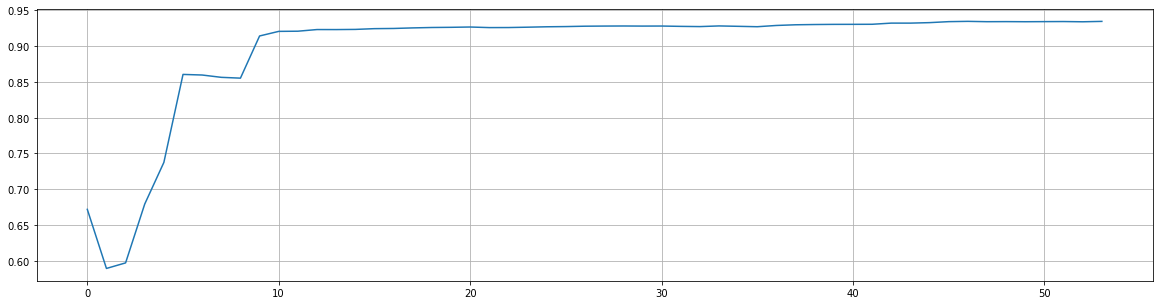

In [154]:
# выведем график значений коэфф-та детерминации, рассчитанного на модели DecisionTreeClassifier путем 
# последовательного добавления признаков в модель (без отбора признаков)
plt.figure(figsize=(20, 5))
plt.plot(score_results_tree)
plt.grid()
plt.show()

Модель дерева решений рассчиталась на порядок быстрее модели лог.регрессии (все варианты в течение 7-8 мин.),
показав при этом очень хороший результат на параметрах "из коробки" (т.е. без настройки основных параметров, 
таких как max_depth, min_samples_leaf, max_features).

Max = 0.9344249127960346 на наборе признаков (49 шт): 
    ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area_0', 'Wilderness_Area_1', 'Wilderness_Area_2', 'Wilderness_Area_3', 'Soil_Type_0', 'Soil_Type_1', 'Soil_Type_2', 'Soil_Type_3', 'Soil_Type_4', 'Soil_Type_5', 'Soil_Type_6', 'Soil_Type_7', 'Soil_Type_8', 'Soil_Type_9', 'Soil_Type_10', 'Soil_Type_11', 'Soil_Type_12', 'Soil_Type_13', 'Soil_Type_14', 'Soil_Type_15', 'Soil_Type_16', 'Soil_Type_17', 'Soil_Type_18', 'Soil_Type_19', 'Soil_Type_20', 'Soil_Type_21', 'Soil_Type_22', 'Soil_Type_23', 'Soil_Type_24', 'Soil_Type_25', 'Soil_Type_26', 'Soil_Type_27', 'Soil_Type_28', 'Soil_Type_29', 'Soil_Type_30', 'Soil_Type_31', 'Soil_Type_32', 'Soil_Type_33', 'Soil_Type_34']
     
Попробуем провести отбор признаков вручную на основании матрицы корреляции и величины корреляции.
В качестве приоритетной использовать будем модель дерева решений как показавшую наилучшие результаты в многоклассовой классификации, в т.ч. в производительности.
Модель "второго выбора" (для сравнения) - лог.регрессия.

In [16]:
# Тепловая карта ранее нам уже показала, что в датасете отсутствуют как сильно коррелирующие между собой признаки,
# так и признаки, сильно коррелирующие с целевой переменной (covtype).

# Для отбора по числовым значениям более удобна будет не тепловая карта, а матрица корреляций с целевой переменной
# (т.е. не полная матрица взаимных корреляций, а только то, что нам нужно).

# Пользуясь этой матрицей, отберем ТОП-10 (к примеру) признаков, к-рые сильнее всего влияют на целевую переменную,
# причем не только положительно (прямо пропорционально), но и отрицательно (обратно пропорционально).
# Соотв-но, возьмем ТОП-5-плюс и ТОП-5-минус.

target_corr = df.corrwith(df['covtype'])
target_corr.sort_values(ascending=False)

covtype                               1.000000
Wilderness_Area_3                     0.323200
Soil_Type_9                           0.243876
Soil_Type_37                          0.160170
Soil_Type_38                          0.155668
Slope                                 0.148285
Soil_Type_39                          0.128351
Soil_Type_1                           0.118135
Soil_Type_5                           0.112958
Soil_Type_3                           0.099672
Soil_Type_0                           0.090828
Soil_Type_16                          0.090582
Vertical_Distance_To_Hydrology        0.081664
Soil_Type_34                          0.080315
Soil_Type_36                          0.080271
Soil_Type_4                           0.077890
Soil_Type_2                           0.068064
Wilderness_Area_2                     0.066846
Soil_Type_13                          0.065562
Soil_Type_10                          0.035379
Soil_Type_35                          0.025397
Soil_Type_12 

In [17]:
# возьмем в построение моделей набор признаков ТОП-5-плюс и ТОП-5-минус:
X_top10 = df[['Wilderness_Area_3', 'Soil_Type_9', 'Soil_Type_37', 'Soil_Type_38', 'Slope', 
                   'Elevation', 'Wilderness_Area_0', 'Horizontal_Distance_To_Roadways', 'Soil_Type_21', 'Soil_Type_22']]
X_top10.shape

(581012, 10)

In [18]:
# посчитаем сперва деревом решений (как приоритетным методом)
model = DecisionTreeClassifier()
X_train, X_test, y_train, y_test = train_test_split(X_top10, y, test_size=0.3, random_state=42)
model.fit(X_train, y_train)

# коэфф-т детерминации на тестовой выборке
score = model.score(X_test, y_test)
print("Коэффициент детерминации на дереве решений, наборе признаков X_top10:", score)

Коэффициент детерминации на дереве решений, наборе признаков X_top10: 0.75635671011566


In [19]:
# теперь лог.регрессией
model = LogisticRegression(max_iter=200)
X_train, X_test, y_train, y_test = train_test_split(X_top10, y, test_size=0.3, random_state=42)
model.fit(X_train, y_train)

# коэфф-т детерминации на тестовой выборке
score = model.score(X_test, y_test)
print("Коэффициент детерминации на лог.регрессии, наборе признаков X_top10:", score)

Коэффициент детерминации на лог.регрессии, наборе признаков X_top10: 0.4961848265100055


C:\Python\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Мы видим, что дерево решений на наборе признаков X_top10 (ТОП-5-плюс и ТОП-5-минус) 
показало достаточно хорошие результаты: 0.75635671011566. 
Но с учетом высокого быстродействия этого способа и результатов на полном наборе признаков(0.90-0.93), нет особого смысла в усечении набора признаков только на основании матрицы корреляций.
    
Логистическая регрессия при отборе на основании матрицы корреляций отработала не очень хорошо: 0.4961848265100055.
    
Попробуем теперь отбор признаков на основе Information Value (задание 4"б"). Судя по комментариям в Slack к указанному заданию, допустимо использовать mutual_info_classif

In [20]:
from sklearn.feature_selection import mutual_info_classif

In [16]:
# максимальный список признаков (full_list) и целевая переменная остаются теми же, как и в модели регрессии
# Но т.к. объем данных большой, то для ускорения преобразуем данные из формата датафрейма в массив(np.array) 
array = df.values
X = array[:, 0:54] # dataframe --> массив numpy  c 0-го по 53-ий признак включительно
y = array[:, 54] # целевую переменную тоже переведем в массив

In [17]:
print(X.shape)
print(y.shape)

(581012, 54)
(581012,)


In [44]:
# рассчитаем показатель взаимного влияния признаков на целевую дискретную переменную
mutual_score = mutual_info_classif(X, y, random_state=42)

In [50]:
for i in range(len(df.columns)-1):
    print(f"{df.columns[i]}\t- {mutual_score[i]:.6f}")

Elevation	- 0.457676
Aspect	- 0.020221
Slope	- 0.038648
Horizontal_Distance_To_Hydrology	- 0.024691
Vertical_Distance_To_Hydrology	- 0.018898
Horizontal_Distance_To_Roadways	- 0.089180
Hillshade_9am	- 0.031489
Hillshade_Noon	- 0.022842
Hillshade_3pm	- 0.022883
Horizontal_Distance_To_Fire_Points	- 0.069493
Wilderness_Area_0	- 0.079245
Wilderness_Area_1	- 0.015368
Wilderness_Area_2	- 0.018647
Wilderness_Area_3	- 0.145996
Soil_Type_0	- 0.011154
Soil_Type_1	- 0.023050
Soil_Type_2	- 0.013311
Soil_Type_3	- 0.027407
Soil_Type_4	- 0.007599
Soil_Type_5	- 0.019945
Soil_Type_6	- 0.000154
Soil_Type_7	- 0.000000
Soil_Type_8	- 0.000000
Soil_Type_9	- 0.064588
Soil_Type_10	- 0.007159
Soil_Type_11	- 0.023574
Soil_Type_12	- 0.009473
Soil_Type_13	- 0.002800
Soil_Type_14	- 0.000550
Soil_Type_15	- 0.000000
Soil_Type_16	- 0.007466
Soil_Type_17	- 0.002416
Soil_Type_18	- 0.001103
Soil_Type_19	- 0.001192
Soil_Type_20	- 0.001987
Soil_Type_21	- 0.023782
Soil_Type_22	- 0.021804
Soil_Type_23	- 0.005691
Soil_Type_2

Отберем, например, признаки с важностью более 5% (mutual_score >= 0.05)
и попробуем посчитать качество дерева решений на этих признаках.

In [51]:
X_mutual = df[['Elevation', 'Horizontal_Distance_To_Roadways', 'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area_0', 
               'Wilderness_Area_3', 'Soil_Type_9']]
X_mutual.shape

(581012, 6)

In [52]:
# приоритетный способ - дерево решений
model = DecisionTreeClassifier()
X_train, X_test, y_train, y_test = train_test_split(X_mutual, y, test_size=0.3, random_state=42)
model.fit(X_train, y_train)

# коэфф-т детерминации на тестовой выборке
score = model.score(X_test, y_test)
print("Коэффициент детерминации на дереве решений, наборе признаков X_mutual:", score)

Коэффициент детерминации на дереве решений, наборе признаков X_mutual: 0.8591196989168349


In [53]:
# теперь лог.регрессия
model = LogisticRegression(max_iter=200)
X_train, X_test, y_train, y_test = train_test_split(X_mutual, y, test_size=0.3, random_state=42)
model.fit(X_train, y_train)

# коэфф-т детерминации на тестовой выборке
score = model.score(X_test, y_test)
print("Коэффициент детерминации на лог.регрессии, наборе признаков X_mutual:", score)

Коэффициент детерминации на лог.регрессии, наборе признаков X_mutual: 0.5260292362768496


C:\Python\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Как видим, дерево решений опять показало неплохие результаты (0.8591196989168349), причем всего на 6-и признаках:
['Elevation', 'Horizontal_Distance_To_Roadways', 'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area_0', 
               'Wilderness_Area_3', 'Soil_Type_9']

Лог.регрессия - не очень (0.5260292362768496), хотя и лучше, 
чем на признаках, отобранных вручную на основании матрицы корреляций (0.4961848265100055).

Попробуем теперь реализовать отбор признаков на основе feature_importance от алгоритма RandomForest (задание 4"в"). 

In [11]:
from sklearn.ensemble import ExtraTreesClassifier

In [60]:
# используем те же массивы X,y, созданные для ускорения расчетов в предыдущем пункте (mutual_info_classif)

# инициализируем и обучим модель классификатора RandomForest
model = ExtraTreesClassifier()
model.fit(X, y) 

ExtraTreesClassifier()

In [61]:
# выведем по каждому признаку значение рассчитанного атрибута feature_importances_
for i in range(len(df.columns)-1):
    print(f"{df.columns[i]}\t- {model.feature_importances_[i]:.6f}")

Elevation	- 0.196449
Aspect	- 0.052375
Slope	- 0.036990
Horizontal_Distance_To_Hydrology	- 0.065030
Vertical_Distance_To_Hydrology	- 0.059104
Horizontal_Distance_To_Roadways	- 0.111606
Hillshade_9am	- 0.043149
Hillshade_Noon	- 0.045203
Hillshade_3pm	- 0.042791
Horizontal_Distance_To_Fire_Points	- 0.105612
Wilderness_Area_0	- 0.010591
Wilderness_Area_1	- 0.006043
Wilderness_Area_2	- 0.011671
Wilderness_Area_3	- 0.041284
Soil_Type_0	- 0.001256
Soil_Type_1	- 0.009888
Soil_Type_2	- 0.002626
Soil_Type_3	- 0.013665
Soil_Type_4	- 0.000561
Soil_Type_5	- 0.002674
Soil_Type_6	- 0.000054
Soil_Type_7	- 0.000050
Soil_Type_8	- 0.000162
Soil_Type_9	- 0.012213
Soil_Type_10	- 0.004190
Soil_Type_11	- 0.015882
Soil_Type_12	- 0.005282
Soil_Type_13	- 0.000599
Soil_Type_14	- 0.000005
Soil_Type_15	- 0.000905
Soil_Type_16	- 0.002007
Soil_Type_17	- 0.000567
Soil_Type_18	- 0.001128
Soil_Type_19	- 0.002016
Soil_Type_20	- 0.001214
Soil_Type_21	- 0.017977
Soil_Type_22	- 0.011814
Soil_Type_23	- 0.004223
Soil_Type_2

Так же отберем признаки с важностью более 5% (feature_importances_[i] >= 0.05)
и попробуем посчитать качество дерева решений на этих признаках, а затем лог.регрессии.

In [63]:
X_random_forest = df[['Elevation', 'Aspect', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 
               'Horizontal_Distance_To_Roadways', 'Horizontal_Distance_To_Fire_Points']]
X_random_forest.shape

(581012, 6)

In [64]:
# приоритетный способ - дерево решений
model = DecisionTreeClassifier()
X_train, X_test, y_train, y_test = train_test_split(X_random_forest, y, test_size=0.3, random_state=42)
model.fit(X_train, y_train)

# коэфф-т детерминации на тестовой выборке
score = model.score(X_test, y_test)
print("Коэффициент детерминации на дереве решений, наборе признаков X_random_forest:", score)

Коэффициент детерминации на дереве решений, наборе признаков X_random_forest: 0.9176955204699835


In [65]:
# теперь лог.регрессия
model = LogisticRegression(max_iter=200)
X_train, X_test, y_train, y_test = train_test_split(X_random_forest, y, test_size=0.3, random_state=42)
model.fit(X_train, y_train)

# коэфф-т детерминации на тестовой выборке
score = model.score(X_test, y_test)
print("Коэффициент детерминации на лог.регрессии, наборе признаков X_random_forest:", score)

Коэффициент детерминации на лог.регрессии, наборе признаков X_random_forest: 0.5021342023131999


C:\Python\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Мы видим, что Random_forest  позволил нам правильнее отобрать наиболее значимые признаки, чем mutual_info_classif:

значение коэфф-та детерм. для Random_forest при использовании дерева решений: 0.9176955204699835 
(количество признаков такое же - 6 шт.,  но их набор отличается в сторону использования всевозможных дистанций: 
['Elevation', 'Aspect', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 
               'Horizontal_Distance_To_Roadways', 'Horizontal_Distance_To_Fire_Points'])
               
Но этот набор признаков, который помог улучшить дерево решений, совсем не улучшил качество модели лог.регрессии: 
оно снизилось с 0.5260292362768496 до 0.5021342023131999.

Попробуем теперь провести "жадные" отбор и удаление признаков (задания 4 "г" и "д" соответственно). Используем модель дерева решений в качестве оценщика(estimator'а).

Если использовать библиотеку scikit-learn (https://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection), то для жадного отбора можно попробовать:
feature_selection.SequentialFeatureSelector: Transformer that performs Sequential Feature Selection.

Для жадного удаления:
feature_selection.RFE: Feature ranking with recursive feature elimination.

In [12]:
# для реализации жадного отбора загрузим SequentialFeatureSelector
from sklearn.feature_selection import SequentialFeatureSelector

In [103]:
# определим модель для оценивания, лучше всего подходило дерево решений
model = DecisionTreeClassifier()

In [104]:
# создадим и обучим селектор (на 3-х признаках(по умолчанию) качество получилось низким, 0.6828357352671195).
# Поэтому увеличил до 6-и - для сопоставимости с результатами mutual_info и Random_forest
sfs = SequentialFeatureSelector(model, n_features_to_select=6)
sfs.fit(X, y)

SequentialFeatureSelector(estimator=DecisionTreeClassifier(),
                          n_features_to_select=6)

In [105]:
# убедимся, что признаки выбраны
sfs.get_support()

array([ True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True, False,  True,
       False, False, False, False, False, False, False, False, False,
        True, False, False, False, False, False, False, False,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True, False, False])

In [106]:
# выведем наименования признаков:
cols = sfs.get_support(indices = True)
sfs_features = df.iloc[:,cols]
sfs_features.columns

Index(['Elevation', 'Soil_Type_1', 'Soil_Type_3', 'Soil_Type_13',
       'Soil_Type_21', 'Soil_Type_37'],
      dtype='object')

In [107]:
X_sfs = df[['Elevation', 'Soil_Type_1', 'Soil_Type_3', 'Soil_Type_13', 'Soil_Type_21', 'Soil_Type_37']]
X_sfs.shape

(581012, 6)

In [108]:
# обучим дерево решений на отобранном наборе признаков X_sfs
model = DecisionTreeClassifier()
X_train, X_test, y_train, y_test = train_test_split(X_sfs, y, test_size=0.3, random_state=42)
model.fit(X_train, y_train)

# коэфф-т детерминации на тестовой выборке
score = model.score(X_test, y_test)
print("Коэффициент детерминации на дереве решений, наборе признаков X_sfs:", score)

Коэффициент детерминации на дереве решений, наборе признаков X_sfs: 0.6889457499541032


In [109]:
# теперь лог.регрессия
model = LogisticRegression(max_iter=200)
X_train, X_test, y_train, y_test = train_test_split(X_sfs, y, test_size=0.3, random_state=42)
model.fit(X_train, y_train)

# коэфф-т детерминации на тестовой выборке
score = model.score(X_test, y_test)
print("Коэффициент детерминации на лог.регрессии, наборе признаков X_sfs:", score)

Коэффициент детерминации на лог.регрессии, наборе признаков X_sfs: 0.6387346245639802


Как видим, качество модели на дереве решений на наборе из 6-и признаков, отобранном SequentialFeatureSelector-ом,
существенно ниже, чем у отобранного с помощью Random Forest: 0.6889457499541032 против 0.9176955204699835.
Причем расчет SequentialFeatureSelector-ом занял гораздо больше времени, чем Random Forest.
    
А вот качество модели лог.регрессии на наборе из 6-и признаков, отобранном SequentialFeatureSelector-ом,
неожиданно оказалось близким (0.6387346245639802) к максимальному результату (0.6511038186157518), 
полученному ранее путем последовательного добавления признаков от одного до всего набора!
И гораздо лучше других сделанных вариантов отбора признаков (0.45-0.55).

Попробуем теперь "жадное" отбрасывание признаков по минимальному падению качества модели (задание 4"д"). 
Воспользуемся feature_selection.RFE: Feature ranking with recursive feature elimination.

In [13]:
from sklearn.feature_selection import RFE

In [14]:
# определим модель для оценивания, лучше всего подходило дерево решений
model = DecisionTreeClassifier()

In [21]:
# создадим и обучим селектор (на 6-и признаках - для сопоставимости с предыдущими результатами).
# откидывать будем по одному признаку (step=1)
RFE_selector = RFE(model, n_features_to_select=6, step=1)
RFE_selector.fit(X, y)

RFE(estimator=DecisionTreeClassifier(), n_features_to_select=6)

In [22]:
# убедимся, что признаки выбраны
RFE_selector.support_

array([ True, False, False,  True, False,  True,  True,  True, False,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False])

In [42]:
# выведем ранжирование признаков, отобранные будут с рангом=1
full_list = ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area_0',
       'Wilderness_Area_1', 'Wilderness_Area_2', 'Wilderness_Area_3',
       'Soil_Type_0', 'Soil_Type_1', 'Soil_Type_2', 'Soil_Type_3',
       'Soil_Type_4', 'Soil_Type_5', 'Soil_Type_6', 'Soil_Type_7',
       'Soil_Type_8', 'Soil_Type_9', 'Soil_Type_10', 'Soil_Type_11',
       'Soil_Type_12', 'Soil_Type_13', 'Soil_Type_14', 'Soil_Type_15',
       'Soil_Type_16', 'Soil_Type_17', 'Soil_Type_18', 'Soil_Type_19',
       'Soil_Type_20', 'Soil_Type_21', 'Soil_Type_22', 'Soil_Type_23',
       'Soil_Type_24', 'Soil_Type_25', 'Soil_Type_26', 'Soil_Type_27',
       'Soil_Type_28', 'Soil_Type_29', 'Soil_Type_30', 'Soil_Type_31',
       'Soil_Type_32', 'Soil_Type_33', 'Soil_Type_34', 'Soil_Type_35',
       'Soil_Type_36', 'Soil_Type_37', 'Soil_Type_38', 'Soil_Type_39']

# выведем наименования признаков:
RFE_ranking = pd.DataFrame(RFE_selector.ranking_, index=full_list, columns=['Rank']).sort_values(by='Rank', ascending=True)
RFE_ranking.head(10)

,Rank
Elevation,1
Horizontal_Distance_To_Hydrology,1
Horizontal_Distance_To_Roadways,1
Hillshade_9am,1
Hillshade_Noon,1
Horizontal_Distance_To_Fire_Points,1
Vertical_Distance_To_Hydrology,2
Aspect,3
Hillshade_3pm,4
Wilderness_Area_0,5


In [43]:
# отобранные признаки с рангом 1
X_RFE = df[['Elevation', 'Horizontal_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 
            'Hillshade_9am', 'Hillshade_Noon', 'Horizontal_Distance_To_Fire_Points']]
X_RFE.shape

(581012, 6)

In [44]:
# обучим дерево решений на отобранном наборе признаков X_RFE
model = DecisionTreeClassifier()
X_train, X_test, y_train, y_test = train_test_split(X_RFE, y, test_size=0.3, random_state=42)
model.fit(X_train, y_train)

# коэфф-т детерминации на тестовой выборке
score = model.score(X_test, y_test)
print("Коэффициент детерминации на дереве решений, наборе признаков X_RFE:", score)

Коэффициент детерминации на дереве решений, наборе признаков X_RFE: 0.9142589957774921


In [45]:
# теперь лог.регрессия
model = LogisticRegression(max_iter=200)
X_train, X_test, y_train, y_test = train_test_split(X_RFE, y, test_size=0.3, random_state=42)
model.fit(X_train, y_train)

# коэфф-т детерминации на тестовой выборке
score = model.score(X_test, y_test)
print("Коэффициент детерминации на лог.регрессии, наборе признаков X_RFE:", score)

Коэффициент детерминации на лог.регрессии, наборе признаков X_RFE: 0.6123496879015972


C:\Python\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Как видим, качество модели на дереве решений на наборе из 6-и признаков, отобранном жадным отбрасыванием 
признаков с помощью RFE(0.9142589957774921), практически такое же, как у отобранного с помощью Random Forest (0.9176955204699835), 
и гораздо выше, чем у SequentialFeatureSelector-а (0.6889457499541032).

Качество лог.регрессии снизилось по сравнению с признаками, отобранными SequentialFeatureSelector-ом 
(с 0.6387346245639802 до 0.6123496879015972).

Общий вывод: лучше всего отработал метод классификации с помощью дерева решений (DecisionTreeClassifier) - выше 0.90, 
гораздо лучше, чем логистическая регрессия (максимум 0.65).

Линейная регрессия для задач многоклассовой классификации при целевой дискретной переменной не подходит, 
показывает крайне плохие результаты (на уровне 0.3).

Для отбора признаков лучше всего подошли методы случайного леса (RandomForest) и жадного отбрасывания признаков (RFE).

Методы автоматизированного отбора признаков являются ресурсозатратными, 
но при этом позволяют добиться очень хороших результатов по сравнению с отбором вручную или перебором признаков "в лоб".